# Usage example for the procedure PPXF

which implements the Penalized Pixel-Fitting (pPXF) method originally described in Cappellari M., & Emsellem E., 2004, PASP, 116, 138 http://adsabs.harvard.edu/abs/2004PASP..116..138C and upgraded in Cappellari M., 2017, MNRAS, 466, 798     http://adsabs.harvard.edu/abs/2017MNRAS.466..798C

This example shows how to study stellar population and include gas emission lines as templates instead of masking them using the GOODPIXELS keyword.

### MODIFICATION HISTORY:
* **V1.0.0**: Adapted from PPXF_KINEMATICS_EXAMPLE. Michele Cappellari, Oxford, 12 October 2011
* **V1.1.0**: Made a separate routine for the construction of the templates spectral library. MC, Vicenza, 11 October 2012 
* **V1.1.1**: Includes `regul_error` definition. MC, Oxford, 15 November 2012
* **V2.0.0**: Translated from IDL into Python. MC, Oxford, 6 December 2013
* **V2.0.1**: Fit SDSS rather than SAURON spectrum. MC, Oxford, 11 December 2013
* **V2.1.0**: Includes gas emission as templates instead of masking the spectrum. MC, Oxford, 7 January 2014
* **V2.1.1**: Support both Python 2.6/2.7 and Python 3.x. MC, Oxford, 25 May 2014
* **V2.1.2**: Illustrates how to print and plot emission lines. MC, Oxford, 5 August 2014
* **V2.1.3**: Only includes emission lines falling within the fitted wavelength range. MC, Oxford, 3 September 2014
* **V2.1.4**: Explicitly sort template files as `glob()` output may not be sorted. Thanks to Marina Trevisan for reporting problems under Linux. MC, Sydney, 4 February 2015
* **V2.1.5**: Included `origin='upper'` in `imshow()`. Thanks to Richard McDermid for reporting a different default value with older Matplotlib versions. MC, Oxford, 17 February 2015
* **V2.1.6**: Use `color=` instead of `c=` to avoid new Matplotlib bug. MC, Oxford, 25 February 2015
* **V2.1.7**: Uses Pyfits from Astropy to read FITS files. MC, Oxford, 22 October 2015
* **V2.1.8**: Included treatment of the SDSS/MILES vacuum/air wavelength difference. MC, Oxford, 12 August 2016
* **V2.1.9**: Automate and test computation of nAge and nMetals. MC, Oxford 1 November 2016
* **V3.0.0**: Major upgrade. Compute mass-weighted population parameters and $M/L$ using the new *miles* class which leaves no room for user mistakes. MC, Oxford, 2 December 2016
* **V3.0.1**: Make files paths relative to this file, to run the example from any directory. MC, Oxford, 18 January 2017
* **V3.1.0**: Use ppxf method `pp.plot(gas_component=...)` to produce gas emission lines plot. MC, Oxford, 13 March 2017
* **V3.2.0**: Uses new ppxf keywords `gas_component` and `gas_names` to print the fluxes and formal errors for the gas emission lines. Uses different kinematic components for the Balmer lines and the rest. MC, Oxford, 28 June 2017
* **V3.3.0**: Illustrate how to tie the Balmer emission lines and fit for the gas reddening using the `tie_balmer` keyword. Also limit doublets. MC, Oxford, 31 October 2017
* **V3.3.1**: Changed imports for pPXF as a package. Make file paths relative to the pPXF package to be able to run the example unchanged from any directory. MC, Oxford, 17 April 2018
* **V3.3.2**: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018 

# Libraries

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import ppxf as ppxf_package
import ppxf.ppxf_util    as util
import ppxf.miles_util   as lib
from time       import clock
from os         import path
from astropy.io import fits
from ppxf.ppxf  import ppxf

In [2]:
%matplotlib notebook

# Function - actual example

In [3]:
def ppxf_example_population_gas_sdss(tie_balmer, limit_doublets):
    
    # Setup galaxy(ies) ----------------------------------------------------------------------------------------------
    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    ## The spectrum is *already* log rebinned by the SDSS DR8 pipeline and log_rebin should not be used in this case.
    ## Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
    
    file = ppxf_dir + '/spectra/NGC3522_SDSS_DR8.fits'
    hdu = fits.open(file)
    t = hdu[1].data
    z = float(hdu[1].header["Z"])           # SDSS redshift estimate
    
    mask = (t['wavelength'] > 3540) & (t['wavelength'] < 7409) # Only use the wavelength range in common between 
                                                               # galaxy and stellar library.
    flux = t['flux'][mask]
    galaxy = flux/np.median(flux)                              # Normalize spectrum to avoid numerical issues
    wave = t['wavelength'][mask]

    ## The SDSS wavelengths are in vacuum, while the MILES ones are in air. For a rigorous treatment, the SDSS vacuum 
    ## wavelengths should be converted into air wavelengths and the spectra should be resampled. To avoid resampling, 
    ## given that the wavelength dependence of the correction is very weak, I approximate it with a constant factor.
    
    wave *= np.median(util.vac_to_air(wave)/wave)

    ## The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0). A constant noise is not a bad 
    ## approximation in the fitted wavelength range and reduces the noise in the fit.
    
    noise = np.full_like(galaxy, 0.01635)                       # Assume constant noise per pixel here

    ## The velocity step was already chosen by the SDSS pipeline and we convert it below to km/s
    c = 299792.458                                              # speed of light in km/s
    velscale = c*np.log(wave[1]/wave[0])                        # eq.(8) of Cappellari (2017)
    FWHM_gal = 2.76                                 # SDSS has an approximate instrumental resolution FWHM of 2.76A.

    # Setup templates ------------------------------------------------------------------------------------------------
    pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
    miles = lib.miles(pathname, velscale, FWHM_gal)

    ## The stellar templates are reshaped below into a 2-dim array with each spectrum as a column, however we save the 
    ## original array dimensions, which are needed to specify the regularization dimensions
    reg_dim = miles.templates.shape[1:]
    stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)
    regul_err = 0.013  # Desired regularization error. See the pPXF documentation for the keyword REGUL

    # Construct a set of Gaussian emission line templates. Estimate the wavelength fitted range in the rest frame.
    lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + z)
    gas_templates, gas_names, line_wave = util.emission_lines(miles.log_lam_temp, lam_range_gal, FWHM_gal,
                                                              tie_balmer=tie_balmer, limit_doublets=limit_doublets)
#     print (miles.log_lam_temp[0])
#     print ("gas templates:", gas_templates.shape)
#     print ("gas names:", gas_names)
#     print ("line wl:", line_wave)
    
    ## Combines the stellar and gaseous templates into a single array. During the PPXF fit they will be assigned a 
    ## different kinematic COMPONENT value:
    templates = np.column_stack([stars_templates, gas_templates])

    # Other parameters ----------------------------------------------------------------------------------------------
    ## The galaxy and the template spectra do not have the same starting wavelength. For this reason an extra velocity 
    ## shift DV has to be applied to the template to fit the galaxy spectrum. We remove this artificial shift by using
    ## the keyword VSYST in the call to PPXF below, so that all velocities are measured with respect to DV. This 
    ## assumes that the redshift is negligible. In the case of a high-redshift galaxy one should de-redshift its
    ## wavelength to the rest frame before using the line below as described in PPXF_EXAMPLE_KINEMATICS_SAURON and 
    ## Sec.2.4 of Cappellari (2017)
    
    c     = 299792.458
    dv    = c*(miles.log_lam_temp[0] - np.log(wave[0]))  # eq.(8) of Cappellari (2017)
    vel   = c*np.log(1 + z)                              # eq.(8) of Cappellari (2017)
    start = [vel, 180.]                                  # (km/s), starting guess for [V, sigma]
    print(z, vel, start)

    n_temps     = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer    = len(gas_names) - n_forbidden

    ## Assign component=0 to the stellar templates, component=1 to the Balmer gas emission lines templates and 
    ## component=2 to the forbidden lines.
    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates

    ## Fit (V, sig, h3, h4) moments=4 for the stars
    ## and (V, sig) moments=2 for the two gas kinematic components
    moments = [4, 2, 2]

    ## Adopt the same starting value for the stars and the two gas components
    start = [start, start, start]

    ## If the Balmer lines are tied one should allow for gas reddeining.
    ## The gas_reddening can be different from the stellar one, if both are fitted.
    gas_reddening = 0 if tie_balmer else None
    

    # Here the actual fit starts -------------------------------------------------------------------------------------
    # ----------------------------------------------------------------------------------------------------------------
    
    ## IMPORTANT: Ideally one would like not to use any polynomial in the fit as the continuum shape contains 
    ## important information on the population. Unfortunately this is often not feasible, due to small calibration
    ## uncertainties in the spectral shape. To avoid affecting the line strength of the spectral features, we exclude 
    ## additive polynomials (DEGREE=-1) and only use multiplicative ones (MDEGREE=10). This is only recommended for 
    ## population, not for kinematic extraction, where additive polynomials are always recommended.
    
    t = clock()
    pp = ppxf(templates, galaxy, noise, velscale, start, plot=False, moments=moments, degree=-1, mdegree=10, vsyst=dv,
              lam=wave, clean=False, regul=1./regul_err, reg_dim=reg_dim, component=component, 
              gas_component=gas_component, gas_names=gas_names, gas_reddening=gas_reddening)

    ## When the two Delta Chi^2 below are the same, the solution is the smoothest consistent with the observed 
    ## spectrum.
    
    print('Desired Delta Chi^2: %.4g' % np.sqrt(2*galaxy.size))
    print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*galaxy.size))
    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
    weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

    miles.mean_age_metal(weights)
    miles.mass_to_light(weights, band="r")

    # Plot fit results for stars and gas.
    plt.clf()
    plt.subplot(211)
    pp.plot()

    # Plot stellar population mass fraction distribution
    plt.subplot(212)
    miles.plot(weights)
    plt.tight_layout()
    plt.pause(1)


 Fit with free Balmer lines and [SII] doublet: 

Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']
0.00401801 1202.155571713705 [1202.155571713705, 180.0]
Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1212        98    -0.032     0.048
 comp. 1:      1207        78
 comp. 2:      1197        68
chi2/DOF: 1.029
method = capfit ; Jac calls: 5 ; Func calls: 97 ; Status: 2
Nonzero Templates:  42  /  159
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta     0.1147      0.04    1207    78
Comp: 1        Hgamma     0.2409      0.04    1207    78
Comp: 1         Hbeta     0.4321     0.039    1207    78
Comp: 1        Halpha      1.131     0.036    1207    78
Comp: 2     [SII]6716     0.2433     0.035    1197    68
Comp: 2     [SII]6731  

<IPython.core.display.Javascript object>


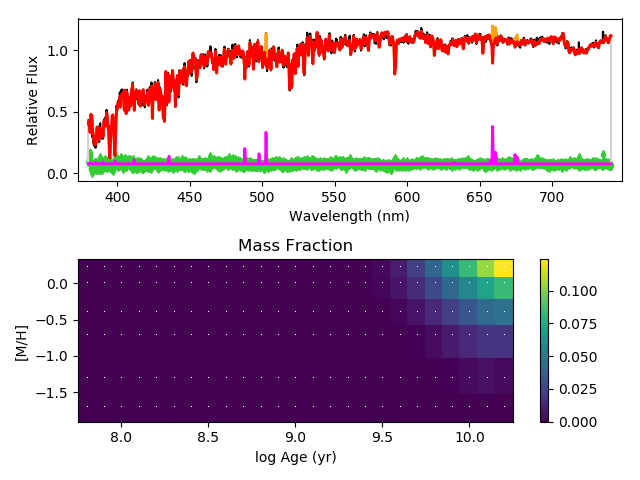


 Fit with tied Balmer lines and limited [SII] doublet: 

Emission lines included in gas templates:
['Balmer' '[SII]6731_d1' '[SII]6731_d2' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']
0.00401801 1202.155571713705 [1202.155571713705, 180.0]
Best Fit:       Vel     sigma        h3        h4
 comp. 0:      1213        98    -0.031     0.043
 comp. 1:      1207        78
 comp. 2:      1197        67
chi2/DOF: 1.018
method = capfit ; Jac calls: 5 ; Func calls: 102 ; Status: 2
Gas Reddening E(B-V): 0.049
Nonzero Templates:  39  /  156
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Balmer      2.256     0.066    1207    78
Comp: 2  [SII]6731_d1    0.02499     0.088    1197    67
Comp: 2  [SII]6731_d2     0.3996     0.093    1197    67
Comp: 2  [OIII]5007_d      1.245     0.047    1197    67
Comp: 2    [OI]6300_d    0.05919     0.044    1197    67
Comp: 

In [4]:
if __name__ == '__main__':

    print("\n===============================================\n" +
          " Fit with free Balmer lines and [SII] doublet: \n" +
          "===============================================\n")

    ppxf_example_population_gas_sdss(tie_balmer=False, limit_doublets=False)

    print("\n=======================================================\n" + 
          " Fit with tied Balmer lines and limited [SII] doublet: \n" +
          "=======================================================\n")

    ## Note tha the inclusion of a few extra faint Balmer lines is sufficient to decrease the chi2 of the fit, 
    ## even though the Balmer decrement is fixed. In this case, the best-fitting gas reddening is at the E(B-V)=0 
    ## boundary.
    
    ppxf_example_population_gas_sdss(tie_balmer=True, limit_doublets=True)